<a href="https://colab.research.google.com/github/lenoken/ML-project-fairness-aware-classification/blob/main/SMOTEBoost_Phoneme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import normalize
from collections import Counter

## Phoneme dataset

[Phoneme](https://raw.githubusercontent.com/jbrownlee/Datasets/master/phoneme.csv). There are 3818 examples of majority class and 1586 examples of minority class with 5 features and  class labels are 0 and 1 for nasal and oral respectively.

In [27]:
df = pd.read_csv("phoneme.csv", header=None, names = ['1', '2', '3', '4', '5', 'class'])
y = df['class'].values
y = y.astype('int')

X = df.drop(columns=['class'])
X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.1,
                                                    random_state=42)

##Class SMOTEBoost

In [6]:
# y - true label
def ada_boost_eps(y, y_pred_t, distribution):
  eps = np.sum((1 - (y == y_pred_t) + (np.logical_not(y) == y_pred_t)) * distribution)
  return eps

def ada_boost_betta(eps):
  betta = eps/(1 - eps)
  return betta

def ada_boost_w(y, y_pred_t):
  w = 0.5 * (1 + (y == y_pred_t) - (np.logical_not(y) == y_pred_t))
  return w

def ada_boost_distribution(distribution, betta, w):
  distribution = distribution * betta ** w  / np.sum(distribution)
  return distribution

def min_target(y):
  minority_target = min(Counter(y), key=Counter(y).get)
  return minority_target

In [7]:
class SMOTEBoost():
    
    def __init__(self,
                 n_samples = 100,
                 k_neighbors = 5,  
                 n_estimators = 50, #n_estimators = T
                 base_classifier = None,
                 random_state = 42,
                 get_eps = ada_boost_eps,
                 get_betta = ada_boost_betta,
                 get_w = ada_boost_w,
                 update_distribution=ada_boost_distribution):
        self.n_samples = n_samples
        self.k_neighbors = k_neighbors
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.random_state = random_state
        self.get_eps = get_eps
        self.get_betta = get_betta
        self.get_w = get_w
        self.update_distribution = update_distribution
        
    def fit(self, X, y):
        
        distribution = np.ones(X.shape[0], dtype=float) / X.shape[0]
        self.classifiers = []
        self.betta = []

        for i in range(self.n_estimators):

            minority_class = min_target(y)
            X_min = X[np.where(y == minority_class)]

            # create a new classifier
            self.classifiers.append(self.base_classifier())

            # SMOTE
            self.smote = SMOTE(n_samples=self.n_samples,
                               k_neighbors=self.k_neighbors,
                               random_state=self.random_state)
            self.smote.fit(X_min)
            X_syn = self.smote.sample()
            y_syn = np.full(X_syn.shape[0], fill_value=minority_class, dtype=np.int64)

            # Modify distribution
            distribution_syn = np.empty(X_syn.shape[0], dtype=np.float64)
            distribution_syn[:] = 1. / X.shape[0]
            mod_distribution = np.append(distribution, distribution_syn).reshape(1, -1)
            mod_distribution = np.squeeze(normalize(mod_distribution, axis=1, norm='l1'))
            # Concatenate original and synthetic datasets for training a weak learner
            mod_X = np.vstack((X, X_syn))
            mod_y = np.append(y, y_syn) 

            # Train a weak lerner
            self.classifiers[-1].fit(mod_X, mod_y, sample_weight=mod_distribution)

            # Make a prediction for the original dataset
            y_pred_t = self.classifiers[-1].predict(X)
            
            # Compute the pseudo-loss of hypothesis
            eps_t = ada_boost_eps(y, y_pred_t, distribution)
            betta_t = ada_boost_betta(eps_t)
            w_t = ada_boost_w(y, y_pred_t)
            self.betta.append(betta_t)
            
            # Update distribution and normalize
            #print(f'dist_initial = {distribution}, shape = {distribution.shape}')
            distribution = ada_boost_distribution(distribution, betta_t, w_t)
            #print(f'eps = {eps_t}')
            #print(f'betta = {betta_t}')
            #print(f'w_t = {w_t}')
            #print(f'dist = {distribution}')
          

    
    def predict(self, X):
        N = len(X)
        final_pred = np.zeros((N, 2))
        #get the weighted votes of the classifiers
        for betta, clf in zip(self.betta, self.classifiers):
            yp = clf.predict(X)
            final_pred[range(N), yp] += np.log(1/betta)
        final_pred = np.argmax(final_pred,axis=1)
        return final_pred

## Class Smote

In [8]:
class SMOTE():

    def __init__(self, n_samples, k_neighbors=5, random_state=None):
        self.n_samples = n_samples
        self.k = k_neighbors
        self.random_state = random_state

    def fit(self, X):
        self.X = X
        self.n_features = self.X.shape[1]
        self.neigh = NearestNeighbors(n_neighbors=self.k) #k + 1
        self.neigh.fit(self.X)
        return self

    def sample(self):
        np.random.seed(seed=self.random_state)
        S = np.zeros(shape=(self.n_samples, self.n_features))

        for i in range(self.n_samples):
            j = np.random.randint(0, self.X.shape[0])
            nn = self.neigh.kneighbors(self.X[j].reshape(1, -1),
                                       return_distance=False)[:, 1:]
            nn_index = np.random.choice(nn[0])
            dif = self.X[nn_index] - self.X[j]
            gap = np.random.random() 
            S[i, :] = self.X[j, :] + gap * dif[:]
        return S

## Plot F-value

To begin with, we need to determine the optimal parameter SMOTE for our dataset.

In [32]:
max_depth = 5
n_samples = [100, 200, 300, 500] # SMOTE parameter
k_neighbors = 5
n_estimators = 25 # T
random_state = 42

f1 = [0]*4
recall = [0]*4
precision = [0]*4

for i in range(4):
    get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
    smoteboost1 = SMOTEBoost(n_samples = n_samples[i],
                                k_neighbors = k_neighbors,
                                n_estimators = n_estimators,
                                base_classifier = get_base_clf,
                                random_state = random_state)
    smoteboost1.fit(X_train, y_train)
    y_pred = smoteboost1.predict(X_test)
    f1[i] = f1_score(y_test, y_pred)
    recall[i] = precision_score(y_test, y_pred)
    precision[i] = recall_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
d = {"SMOTE":pd.Series(n_samples), "Recall": pd.Series(recall), "Precision": pd.Series(precision), "F-value": pd.Series(f1)}
df = pd.DataFrame(d)
df

,SMOTE,Recall,Precision,F-value
0,100,0.624161,0.641379,0.632653
1,200,0.556122,0.751724,0.639296
2,300,0.648649,0.827586,0.727273
3,500,0.000000,0.000000,0.000000


According to the table above, f-value has a maximum value at SMOTE = 300. Let us plot for this parameter the dependence of f-value on the amount of boosting rounds using SMOOTEBoost and AdaBoost.

In [42]:
max_depth = 5
n_samples = 300
k_neighbors = 5
n_estimators = list(range(1,26))
random_state = 42
f = [0]*25

for i in range(25):
    get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
    smoteboost1 = SMOTEBoost(n_samples = n_samples,
                                k_neighbors = k_neighbors,
                                n_estimators = n_estimators[i],
                                base_classifier = get_base_clf,
                                random_state = random_state)
    smoteboost1.fit(X_train, y_train)
    y_pred = smoteboost1.predict(X_test)
    f[i] = f1_score(y_test, y_pred)

In [43]:
n_estimators = list(range(1,26))
f_ada = [0]*25
for i in range(25):
    clf = AdaBoostClassifier(n_estimators= n_estimators[i], random_state=42)
    clf.fit(X_train, y_train)
    y_pred_ada = clf.predict(X_test)
    f_ada[i] = f1_score(y_test, y_pred_ada)

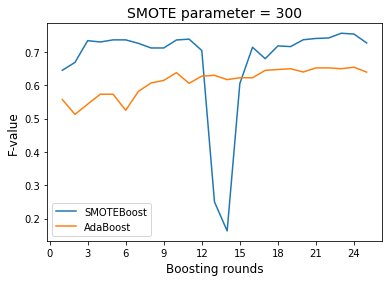

In [45]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator
fig1, ax = plt.subplots()
plt.plot(list(range(1,26)),f, label = 'SMOTEBoost')
plt.plot(list(range(1,26)),f_ada, label = 'AdaBoost')
plt.xlabel('Boosting rounds', size = 12)
plt.ylabel('F-value', size = 12)
plt.title('SMOTE parameter = 300', size = 14)
plt.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('f_value.pdf')
with PdfPages('f_value.pdf') as pdf:
    pdf.savefig(fig1)
plt.show()

The f-value of the algorithm SMOOTEBoost is higher than AdaBoost.